<a href="https://colab.research.google.com/github/YongeBai/SkLearn_Workshop/blob/main/SKlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import pandas as pd
import numpy as np

#1. Gather Data

In [ ]:
#load in dataset
url = 'https://raw.githubusercontent.com/YongeBai/SkLearn_Workshop/main/dataset.csv'
df_raw = pd.read_csv(url)

In [ ]:
df_raw.head()

,Unnamed: 0,hospital_death,patient_id,gender,height,ethnicity,age,weight,bmi,gender.1,d1_lactate_max,d1_lactate_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,0,0,25312,M,180.3,Caucasian,68.0,73.9,22.73,M,1.3,1.0,0.10,0.05
1,1,0,59342,F,160.0,Caucasian,77.0,70.2,27.42,F,3.5,3.5,0.47,0.29
2,2,0,50777,F,172.7,Caucasian,25.0,95.3,31.95,F,NaN,NaN,0.00,0.00
3,3,0,46918,F,165.1,Caucasian,81.0,61.7,22.64,F,NaN,NaN,0.04,0.03
4,4,0,34377,M,188.0,Caucasian,19.0,NaN,NaN,M,NaN,NaN,NaN,NaN


In [ ]:
df_raw.columns

Index(['Unnamed: 0', 'hospital_death', 'patient_id', 'gender', 'height',
       'ethnicity', 'age', 'weight', 'bmi', 'gender.1', 'd1_lactate_max',
       'd1_lactate_min', 'apache_4a_hospital_death_prob',
       'apache_4a_icu_death_prob'],
      dtype='object')

#2. Preprocess data

In [ ]:
# remove irrelavant cols
remove = ['Unnamed: 0', 'patient_id', 'ethnicity', 'gender.1']
df = df_raw.drop(labels=remove, axis=1)


In [ ]:
# replaceing Female and Male with 0 and 1
df['gender'].replace(['F','M'],[0,1],inplace=True)

In [ ]:
# check if there are any missing or infinite values
print(np.any(np.isnan(df)))
print(np.all(np.isfinite(df)))

True
False


In [ ]:
# replacing missing values with mean
df = df.fillna(df.mean())


In [ ]:
# removing rows with infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [ ]:
df.head()

,hospital_death,gender,height,age,weight,bmi,d1_lactate_max,d1_lactate_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,0,1.0,180.3,68.0,73.90000,22.730000,1.300000,1.000000,0.100000,0.050000
1,0,0.0,160.0,77.0,70.20000,27.420000,3.500000,3.500000,0.470000,0.290000
2,0,0.0,172.7,25.0,95.30000,31.950000,2.927383,2.125128,0.000000,0.000000
3,0,0.0,165.1,81.0,61.70000,22.640000,2.927383,2.125128,0.040000,0.030000
4,0,1.0,188.0,19.0,84.02834,29.185818,2.927383,2.125128,0.086787,0.043955


##2.1 Splitting and Scaling Data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# X are features model with consider, y is the output
X = df.drop(columns=['hospital_death'], inplace = False)
y = df['hospital_death']


In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
print("The size of X train is %.2f"% (X_train.size/X.size))
print("The size of X Test is %.2f"%(X_test.size/X.size))

The size of X train is 0.75
The size of X Test is 0.25


In [ ]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Unbalanced dataset. Keep this in mind
f"total deaths = {y.sum(0)}, total survived = {X.shape[0]-y.sum(0)}"

'total deaths = 7915, total survived = 83798'

#3. Model Selection

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

#4. Training

In [ ]:
# training model
logreg.fit(X_train, y_train)

LogisticRegression()

#5. Evaluation

In [ ]:
# Lets see how our well our model preforms on testing data
logreg.score(X_test, y_test)

0.9233285359152166

In [ ]:
# accuracy if model just guessed that nobody died
null_acc = max(y_test.mean(), 1-y_test.mean())
print(null_acc)

0.9117711195429369


##5.1 Choosing Evaluation metric

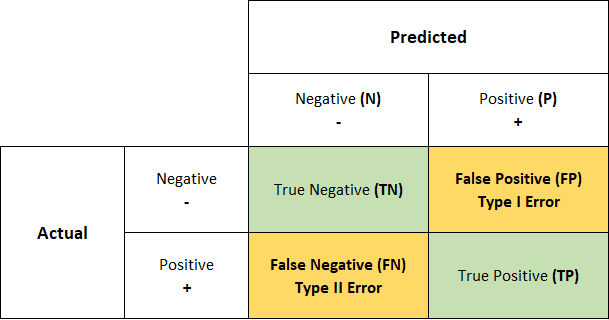

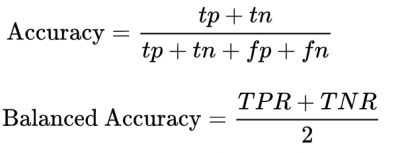

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred), '\n')

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     20906
           1       0.71      0.22      0.34      2023

    accuracy                           0.92     22929
   macro avg       0.82      0.61      0.65     22929
weighted avg       0.91      0.92      0.90     22929

[[20725   181]
 [ 1577   446]] 



In [ ]:
# since we have such an unbalanced dataset, accuracy isnt the best metric
default_score = balanced_accuracy_score(y_test, y_pred)
print(default_score)

0.6059034274313774


#6. Parameter Tuning (Randomized Search)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from time import perf_counter

In [ ]:
params = dict(
    C = [0.1,0.5, 1.5, 2], # inverse of regularization
    class_weight = [{0:1, 1:x} for x in range(1,5)], # how much focus should each class have
    max_iter = [100, 500, 1000, 1500] # num iteration
)

In [ ]:
#finding out how long 1 iter of rand takes
rand = RandomizedSearchCV(
    logreg, 
    params, 
    n_iter=1,
    scoring = 'balanced_accuracy',
)

time_start = perf_counter()
rand.fit(X_train, y_train)
time_stop = perf_counter()
 
print("Each iteration takes:", time_stop - time_start, "seconds")

Each iteration takes: 3.080356781000006 seconds


In [ ]:
rand = RandomizedSearchCV(
    logreg, 
    params, 
    n_iter=30,
    scoring = 'balanced_accuracy',
)

rand.fit(X_train, y_train)

RandomizedSearchCV(estimator=LogisticRegression(), n_iter=30,
                   param_distributions={'C': [0.1, 0.5, 1.5, 2],
                                        'class_weight': [{0: 1, 1: 1},
                                                         {0: 1, 1: 2},
                                                         {0: 1, 1: 3},
                                                         {0: 1, 1: 4}],
                                        'max_iter': [100, 500, 1000, 1500]},
                   scoring='balanced_accuracy')

In [ ]:
rand.best_params_

{'max_iter': 1000, 'class_weight': {0: 1, 1: 4}, 'C': 2}

#7. Prediction

In [ ]:
logreg = LogisticRegression(max_iter=1500, class_weight={0: 1, 1: 4}, C=2)

In [ ]:
# fit new model
logreg.fit(X_train, y_train)

LogisticRegression(C=2, class_weight={0: 1, 1: 4}, max_iter=1500)

In [ ]:
# predict
y_pred = logreg.predict(X_test)

In [ ]:
new_score = balanced_accuracy_score(y_test, y_pred)

In [ ]:
# compare

print("Before: ", default_score)
print("After: ", new_score)

Before:  0.6059034274313774
After:  0.6926650677828714


# Now you can predict if someone will die :)